# Configure Your Pipeline

Before running the notebook, make sure to set the following parameters according to your needs:

- **MODEL** — choose the machine learning model to use:
  `"RandomForest"` or `"LogisticRegression"`

- **DATASET** — select which dataset to process:
  `"OpenStack"` or `"Linux"`

- **SKIP_PIPELINE** — set to `True` if you want to skip the preprocessing pipeline (use existing CSVs), or `False` to run the full pipeline.


In [12]:
MODEL = "RandomForest" # Options: "RandomForest", "LogisticRegression"
DATASET = "Linux"  # Options: "OpenStack", "Linux"
SKIP_PIPELINE = False

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from pipeline import run_pipeline

In [14]:
df = run_pipeline(DATASET, SKIP_PIPELINE)

In [15]:
X = df.iloc[:, 1:-1].values
y = df["Severity"].values

# 10-Fold Cross-Validation Setup

In [16]:
if DATASET == "Linux":
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

if DATASET == "OpenStack":
    from sklearn.model_selection import LeavePOut
    abnormal_idx = np.where(y == 1)[0]
    normal_idx   = np.where(y == 0)[0]

In [17]:
if MODEL == "RandomForest":
    model = RandomForestClassifier(
        n_estimators=100,  # number of trees
        max_depth=None,    # let trees expand until all leaves are pure
        random_state=42,
        class_weight='balanced',
    )
elif MODEL == "LogisticRegression":
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
else:
    raise ValueError(f"Unsupported model {MODEL}, please choose either 'RandomForest' or 'LogisticRegression'.")



# Model Evaluation Across Folds

In [18]:
accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []

y_true_all = []
y_pred_all = []
y_proba_all = []

if DATASET == "Linux":

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]  # probabilities for class 1

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_proba_all.extend(y_proba)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, zero_division=0))
        recalls.append(recall_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_proba))

if DATASET == "OpenStack":
    from imblearn.over_sampling import SMOTE
    lpo = LeavePOut(p=1)
    splits = []

    for train_ab, test_ab in lpo.split(abnormal_idx):

        # abnormal indices for train/test
        train_ab_idx = abnormal_idx[train_ab]    # 3 abnormal
        test_ab_idx  = abnormal_idx[test_ab]     # 1 abnormal

        # normal samples
        normal_idx = np.where(y == 0)[0]

        # ----- Build final train/test indexes -----
        train_idx = np.concatenate([train_ab_idx, normal_idx])
        test_idx  = np.concatenate([test_ab_idx, normal_idx])

        # ----- Split X and y -----
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # ----- Oversample the training set -----
        minority_count = sum(y_train == 1)
        k_neighbors = min(2, minority_count - 1)  # must be < number of minority samples
        sm = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=k_neighbors)  # balance classes
        X_res, y_res = sm.fit_resample(X_train, y_train)

        # ----- Train & Predict -----
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # ----- Store predictions -----
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_proba_all.extend(y_proba)

        # ----- Compute metrics per fold -----
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, zero_division=0))
        recalls.append(recall_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_proba))

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_proba_all = np.array(y_proba_all)

metrics = {
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "AUC": aucs
}

metric_names = list(metrics.keys())
means = [np.mean(metrics[m]) for m in metric_names]
stds = [np.std(metrics[m]) for m in metric_names]

for name, mean, std in zip(metric_names, means, stds):
    print(f"{name}: {mean:.4f} ± {std:.4f}")


Accuracy: 0.9995 ± 0.0000
Precision: 0.0000 ± 0.0000
Recall: 0.0000 ± 0.0000
AUC: 0.5712 ± 0.0000


# Visualizations : Confusion Matrix

<Figure size 500x500 with 0 Axes>

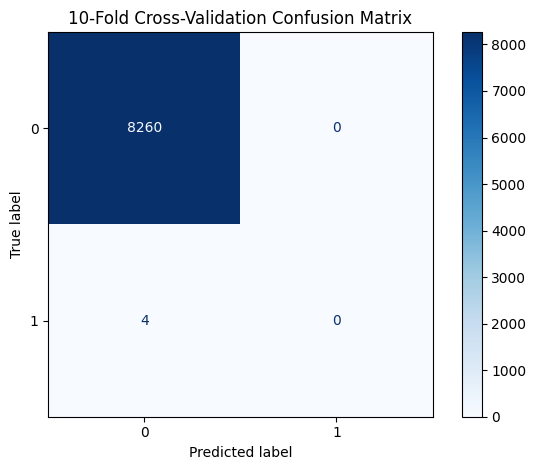

In [19]:
cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", colorbar=True)
plt.title("10-Fold Cross-Validation Confusion Matrix")
plt.tight_layout()
plt.savefig(f"resources/images/cv_confusion_matrix_{MODEL}_{DATASET}.png", dpi=300)
plt.show()

# Feature Importance Analysis

In [20]:
event_names = list(df.columns)[1:-1]

if MODEL == "LogisticRegression":
    coefficients = model.coef_[0]
    importance = np.abs(coefficients)
elif MODEL == "RandomForest":
    importance = abs(model.feature_importances_)

feature_importance = pd.DataFrame({
    "EventId": event_names,
    "Importance": importance
})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance.head(10))

           EventId  Importance
2   other-260455e3    0.980661
12  other-b81be278    0.003003
9   other-62e5177f    0.002123
7   other-61ff7648    0.001914
15  other-fcc9fd98    0.001561
10  other-8b0cbaf4    0.001534
5   other-43086031    0.001461
0   other-046cebb5    0.001390
13  other-d33d94b5    0.001199
6   other-5c93e2c1    0.001191


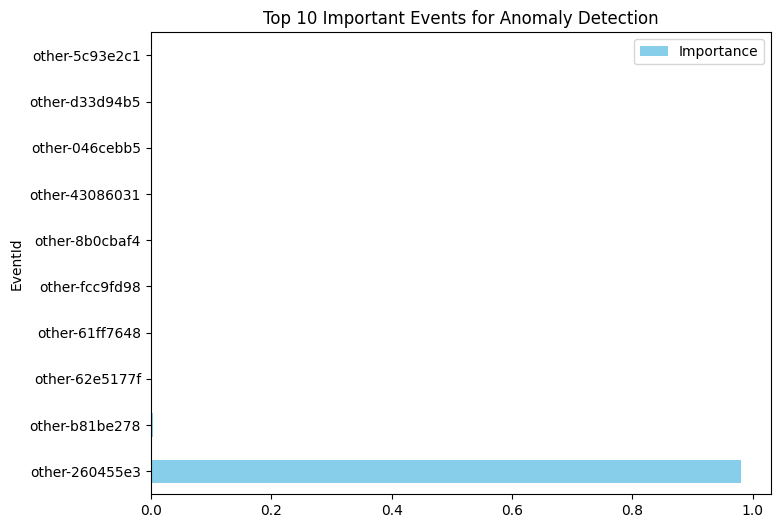

In [21]:
import matplotlib.pyplot as plt

feature_importance.head(10).plot(
    x="EventId", y="Importance", kind="barh", figsize=(8,6), color="skyblue"
)
plt.title("Top 10 Important Events for Anomaly Detection")
plt.savefig(f"resources/images/top10_feature_importance_{MODEL}_{DATASET}.png", dpi=300)
plt.show()
